In [1]:
import itertools, functools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from multiprocessing import Pool, freeze_support

np.random.seed(42)

# from google.colab import drive
# drive.mount("/content/drive")

# import sys
# sys.path.insert(0, "/content/drive/My Drive/INF8953DE")

from frozen_lake import FrozenLakeEnv
from src import *
from utils import *

# 1) Monte Carlo methods
## 1.1) `generate_episode` function

## 1.2) First-visit $\epsilon$-soft Monte Carlo control
### 1.2.a) Average returns
100 independent environments are instanciated, each of them with its own seed. The first-visit MC control algorithm is then excuted in parllel for faster computation, with each run in its own process (to circumvent Python's global interpreter lock).

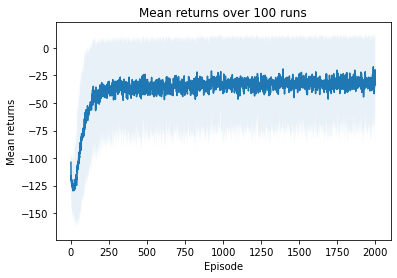

In [2]:
# Generate n_runs independent environments
n_runs = 100
envs = n_runs * [FrozenLakeEnv(map_name="4x4", slip_rate=0.1)]
for i, env in enumerate(envs):
    # Initialize each environment with its own seed
    env.seed(i)
    env.reset()

# Run in parallel
with Pool() as pool:
    fn = functools.partial(first_visit_epsilon_soft_mc_control, epsilon=0.1)
    out = pool.map(fn, envs)

all_returns = np.array([returns for Q, pi, returns in out])
plot_many(all_returns)
plt.xlabel("Episode")
plt.ylabel("Mean returns")
plt.title(f"Mean returns over {n_runs} runs")
plt.show()

### 1.2.b) Vizualizing an episode
We now render an episode using the policy from the first run (arbitrary choice). The policy is displayed as a heatmap here.

Text(0.5, 1.0, 'Policy')

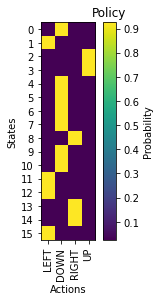

In [3]:
pi = out[0][1]
plot_policy(pi)
plt.title("Policy")

In [4]:
_ = generate_episode(env, pi, render=True)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


### 1.2.c) Average return for the last 100 episodes

Mean return for the last 100 episodes: -31.4627:.1f
Top 5 most common return values: [  -6   -8   -7 -102 -104]


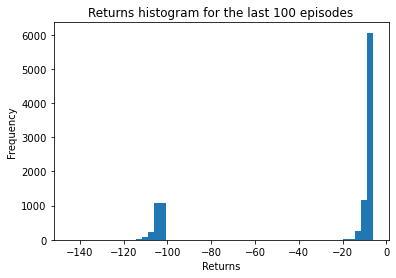

In [5]:
print(f"Mean return for the last 100 episodes: {all_returns[:, -100:].mean():.1f}")

unique, counts = np.unique(all_returns[:, -100:], return_counts=True)
print(f"Top 5 most common return values: {unique[counts.argsort()[::-1]][:5]}")

plt.hist(all_returns[:, -100:].flatten(), 50)
plt.title("Returns histogram for the last 100 episodes")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()

The undiscounted return averaged over the last 100 episodes of all the runs is about -57. This is surprising as we would expect

Even if the policy is perfect, choosing a bad action and falling in a hole is very costly. Given the values of epsilon and the environment's slip rate, there is a quite significant chance of choosing such a bad action.

Big peak at -150: probably due to the maximization bias of MC. Happens to have a lucky episode starting with a bad action. Assigns credit to the bad action. Next episode gets stuck choosing the bad action for 100 steps (-100 reward) and then game over with an extra -50 reward.

## 1.3) Importance sampling
### 1.3.a) Ordinary vs. weighted importance sampling
We plot the state value estimates over time for states $\{0, 3, 7, 14\}$. We keep the same policy as before (the result of the first run of every-visit MC control, `pi`).

In [6]:
# Generate n_runs independent environments
n_runs = 100
envs = n_runs * [FrozenLakeEnv(map_name="4x4", slip_rate=0.1)]
for i, env in enumerate(envs):
    # Initialize each environment with its own seed
    env.seed(i)
    env.reset()

# Run in parallel
with Pool() as pool:
    ois_values = np.stack(
        pool.starmap(ordinary_importance_sampling_mc_prediction, zip(envs, itertools.repeat(pi)))
    )  # (n_runs, n_episodes, env.observation_space.n)

    wis_values = np.stack(
        pool.starmap(weighted_importance_sampling_mc_prediction, zip(envs, itertools.repeat(pi)))
    )  # (n_runs, n_episodes, env.observation_space.n)

State 0:
- Final OIS mean estimate: -48.6 ± 3106.2
- Final WIS mean estimate: -52.1 ± 26.5
----------
State 3:
- Final OIS mean estimate: -30.9 ± 91.8
- Final WIS mean estimate: -97.9 ± 6.2
----------
State 7:
- Final OIS mean estimate: -100.0 ± 0.0
- Final WIS mean estimate: -100.0 ± 0.0
----------
State 14:
- Final OIS mean estimate: -1.4 ± 9.0
- Final WIS mean estimate: -2.6 ± 1.1
----------


C:\Users\Zacharie\AppData\Local\Temp/ipykernel_12932/4228648519.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


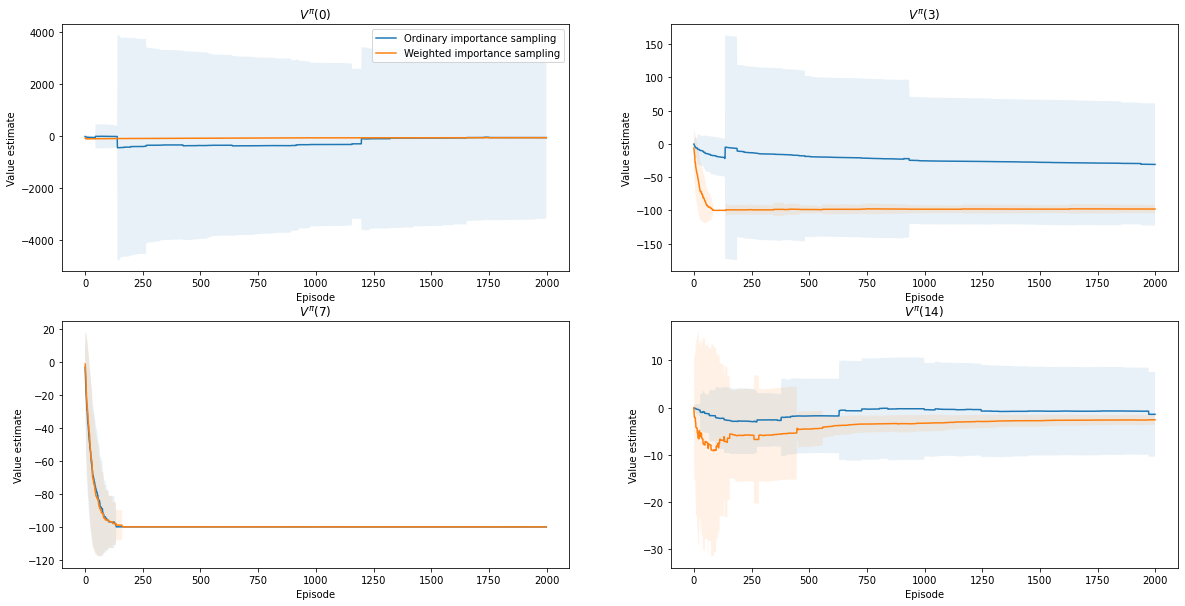

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for s, ax in zip([0, 3, 7, 14], axes.flat):
    ax.set_title(f"$V^\\pi({s})$")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Value estimate")
    plot_many(ois_values[..., s], ax, label="Ordinary importance sampling")
    plot_many(wis_values[..., s], ax, label="Weighted importance sampling")
    print(f"State {s}:")
    print(f"- Final OIS mean estimate: {ois_values[:, -1, s].mean():.1f} ± {ois_values[:, -1, s].std():.1f}")
    print(f"- Final WIS mean estimate: {wis_values[:, -1, s].mean():.1f} ± {wis_values[:, -1, s].std():.1f}")
    print("----------")

axes.flat[0].legend()
fig.show()

The only state for which the OIS estimates have less variability is for $s = 14$, and even then by the end WIS gets better.

# 2) Prediction: Unifying Monte Carlo methods and temporal difference Learning
## 2.1) Every visit Monte Carlo prediction

In [8]:
env = FrozenLakeEnv(map_name="4x4-easy", slip_rate=0)
env.seed(0)
env.reset()

0

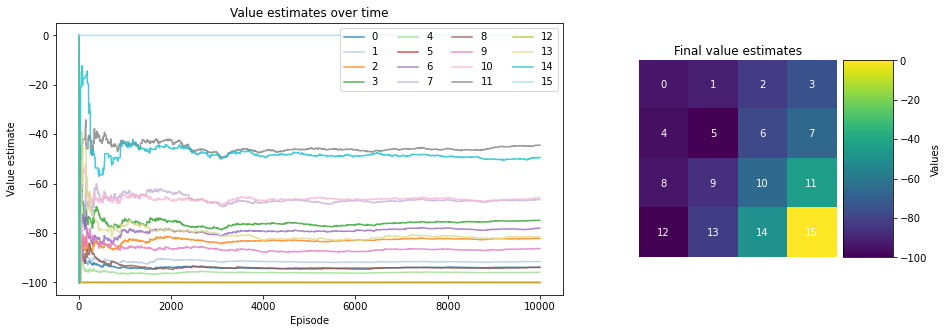

In [9]:
Vs = every_visit_mc_prediction(env, uniform_policy(env.observation_space.n, env.action_space.n))
fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]}, figsize=(15, 5))
plot_all_state_values(Vs, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Value estimate")
axes[0].set_title("Value estimates over time")
plot_policy(Vs[-1].reshape(4, 4), fig, axes[1], cbar_label="Values")
axes[1].set_title("Final value estimates")
axes[1].set_axis_off()
for i in range(Vs[-1].size):
    axes[1].text(i % 4, i // 4, i, ha="center", va="center", color="w")

## 2.2) Tabular TD(0) prediction

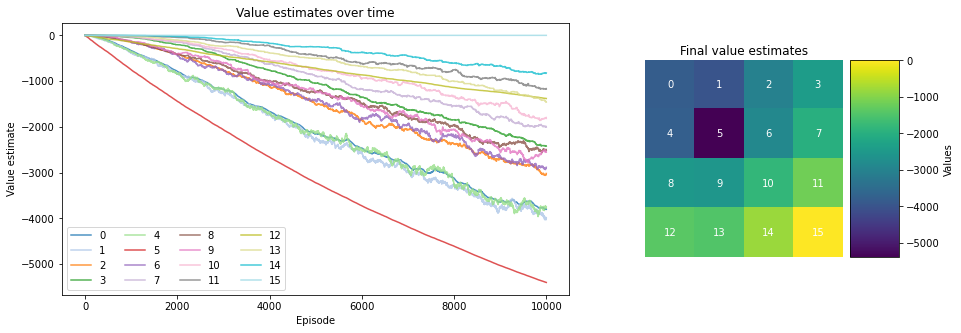

In [10]:
Vs = td_0_prediction(env, uniform_policy(env.observation_space.n, env.action_space.n))
fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]}, figsize=(15, 5))
plot_all_state_values(Vs, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Value estimate")
axes[0].set_title("Value estimates over time")
plot_policy(Vs[-1].reshape(4, 4), fig, axes[1], cbar_label="Values")
axes[1].set_title("Final value estimates")
axes[1].set_axis_off()
for i in range(Vs[-1].size):
    axes[1].text(i % 4, i // 4, i, ha="center", va="center", color="w")

## 2.3) $n$-step TD with $n = 1$

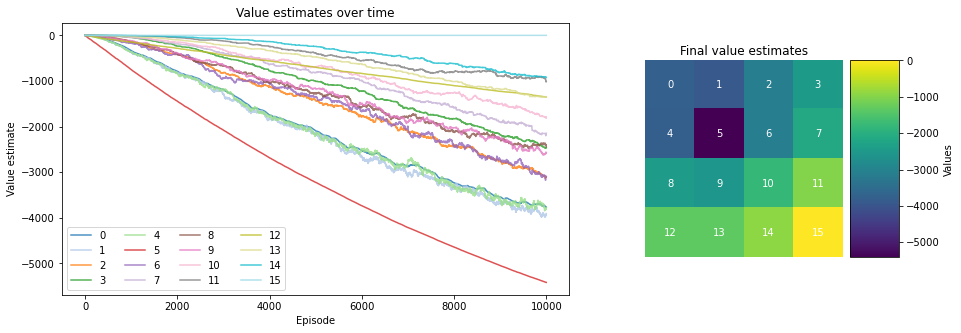

In [11]:
Vs = n_step_td_prediction(env, uniform_policy(env.observation_space.n, env.action_space.n), n=1)
fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]}, figsize=(15, 5))
plot_all_state_values(Vs, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Value estimate")
axes[0].set_title("Value estimates over time")
plot_policy(Vs[-1].reshape(4, 4), fig, axes[1], cbar_label="Values")
axes[1].set_title("Final value estimates")
axes[1].set_axis_off()
for i in range(Vs[-1].size):
    axes[1].text(i % 4, i // 4, i, ha="center", va="center", color="w")

## 2.4) $n$-step TD with $n = 100$

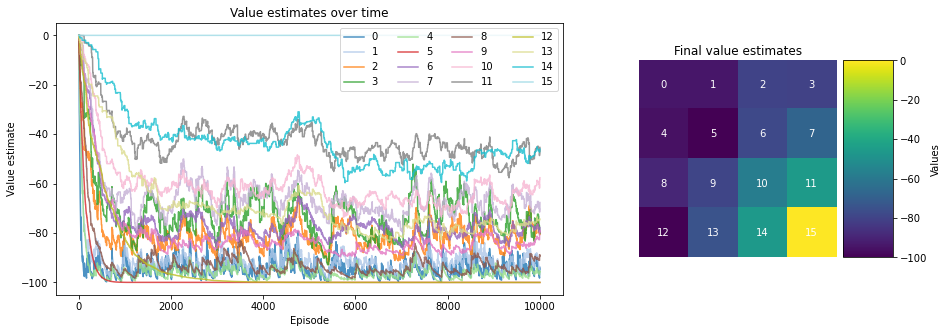

In [12]:
Vs = n_step_td_prediction(env, uniform_policy(env.observation_space.n, env.action_space.n), n=100)
fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]}, figsize=(15, 5))
plot_all_state_values(Vs, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Value estimate")
axes[0].set_title("Value estimates over time")
plot_policy(Vs[-1].reshape(4, 4), fig, axes[1], cbar_label="Values")
axes[1].set_title("Final value estimates")
axes[1].set_axis_off()
for i in range(Vs[-1].size):
    axes[1].text(i % 4, i // 4, i, ha="center", va="center", color="w")

## 2.5) Modifying $n$-step TD

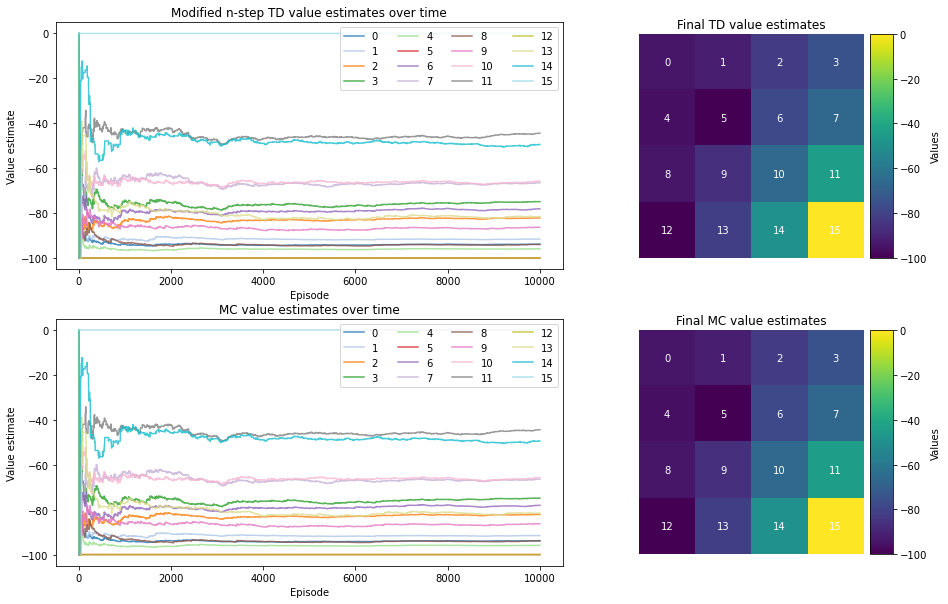

In [13]:
np.random.seed(42)
td_Vs = modified_n_step_td_prediction(env, uniform_policy(env.observation_space.n, env.action_space.n), n=100)

np.random.seed(42)
mc_Vs = every_visit_mc_prediction(env, uniform_policy(env.observation_space.n, env.action_space.n))

fig, axes = plt.subplots(2, 2, gridspec_kw={"width_ratios": [2, 1]}, figsize=(15, 10))

plot_all_state_values(td_Vs, axes.flat[0])
axes.flat[0].set_xlabel("Episode")
axes.flat[0].set_ylabel("Value estimate")
axes.flat[0].set_title("Modified n-step TD value estimates over time")

im = axes.flat[1].imshow(td_Vs[-1].reshape(4, 4))
divider = make_axes_locatable(axes.flat[1])
cax = divider.append_axes("right", size=f"10%", pad=0.1)
fig.colorbar(im, cax=cax, orientation="vertical", label="Values")
axes.flat[1].set_title("Final TD value estimates")
axes.flat[1].set_axis_off()
for i in range(Vs[-1].size):
    axes.flat[1].text(i % 4, i // 4, i, ha="center", va="center", color="w")

plot_all_state_values(mc_Vs, axes.flat[2])
axes.flat[2].set_xlabel("Episode")
axes.flat[2].set_ylabel("Value estimate")
axes.flat[2].set_title("MC value estimates over time")

im = axes.flat[3].imshow(mc_Vs[-1].reshape(4, 4))
divider = make_axes_locatable(axes.flat[3])
cax = divider.append_axes("right", size=f"10%", pad=0.1)
fig.colorbar(im, cax=cax, orientation="vertical", label="Values")
axes.flat[3].set_title("Final MC value estimates")
axes.flat[3].set_axis_off()
for i in range(Vs[-1].size):
    axes.flat[3].text(i % 4, i // 4, i, ha="center", va="center", color="w")

Using the same seed, the plots are indeed identical.

# 3) Temporal difference control methods
## 3.1) SARSA

Text(0.5, 1.0, 'Final Q values from run 0')

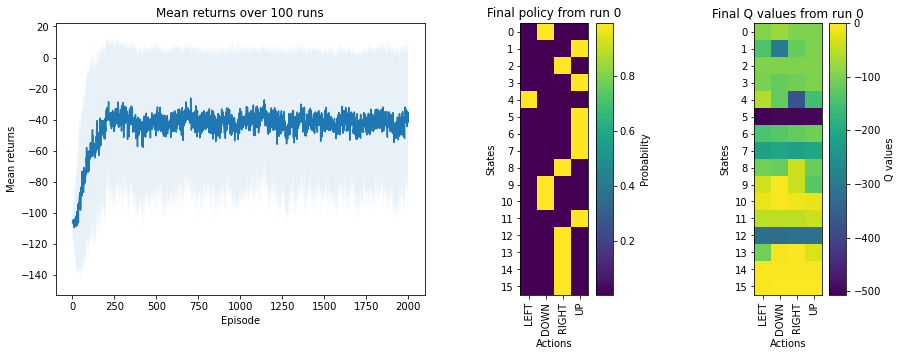

In [14]:
n_runs = 100
envs = n_runs * [FrozenLakeEnv(map_name="4x4", slip_rate=0.1)]
for i, env in enumerate(envs):
    # Initialize each environment with its own seed
    env.seed(i)
    env.reset()

# Run in parallel
with Pool() as pool:
    fn = functools.partial(sarsa)
    out = pool.map(fn, envs)

all_returns = np.array([returns for Q, pi, returns in out])

fig, axes = plt.subplots(1, 3, gridspec_kw={"width_ratios": [2, 1, 1]}, figsize=(15, 5))
plot_many(all_returns, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Mean returns")
axes[0].set_title(f"Mean returns over {n_runs} runs")

pi = out[0][1]
plot_policy(pi, fig, axes[1])
axes[1].set_title("Final policy from run 0")

Q = out[0][0]
plot_policy(Q, fig, axes[2], "Q values")
axes[2].set_title("Final Q values from run 0")

In [15]:
_ = generate_episode(env, pi, render=True)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


## 3.2) Expected SARSA

Text(0.5, 1.0, 'Final Q values from run 0')

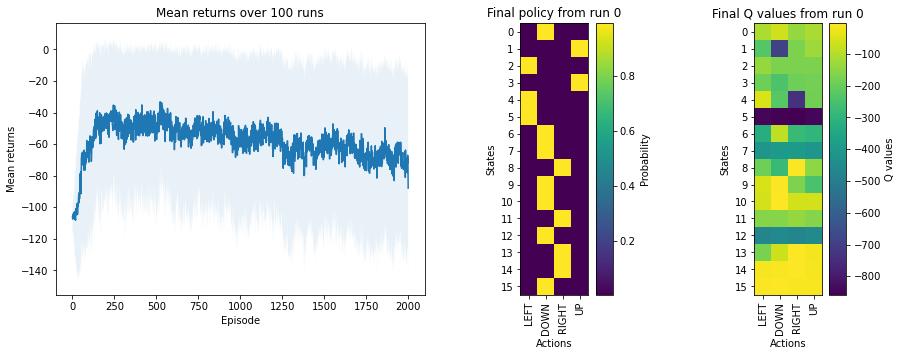

In [16]:
n_runs = 100
envs = n_runs * [FrozenLakeEnv(map_name="4x4", slip_rate=0.1)]
for i, env in enumerate(envs):
    # Initialize each environment with its own seed
    env.seed(i)
    env.reset()

# Run in parallel
with Pool() as pool:
    fn = functools.partial(expected_sarsa)
    out = pool.map(fn, envs)

all_returns = np.array([returns for Q, pi, returns in out])

fig, axes = plt.subplots(1, 3, gridspec_kw={"width_ratios": [2, 1, 1]}, figsize=(15, 5))
plot_many(all_returns, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Mean returns")
axes[0].set_title(f"Mean returns over {n_runs} runs")

pi = out[0][1]
plot_policy(pi, fig, axes[1])
axes[1].set_title("Final policy from run 0")

Q = out[0][0]
plot_policy(Q, fig, axes[2], "Q values")
axes[2].set_title("Final Q values from run 0")

In [17]:
_ = generate_episode(env, pi, render=True)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


## 3.3) Q-learning

Text(0.5, 1.0, 'Final Q values from run 0')

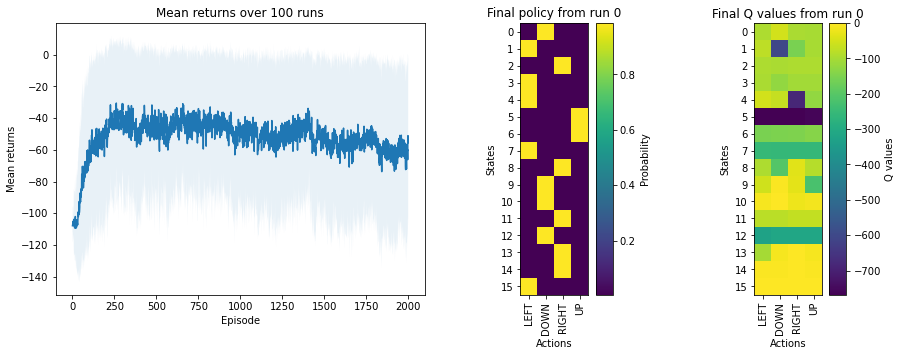

In [18]:
n_runs = 100
envs = n_runs * [FrozenLakeEnv(map_name="4x4", slip_rate=0.1)]
for i, env in enumerate(envs):
    # Initialize each environment with its own seed
    env.seed(i)
    env.reset()

# Run in parallel
with Pool() as pool:
    fn = functools.partial(q_learning)
    out = pool.map(fn, envs)

all_returns = np.array([returns for Q, pi, returns in out])

fig, axes = plt.subplots(1, 3, gridspec_kw={"width_ratios": [2, 1, 1]}, figsize=(15, 5))
plot_many(all_returns, axes[0])
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Mean returns")
axes[0].set_title(f"Mean returns over {n_runs} runs")

pi = out[0][1]
plot_policy(pi, fig, axes[1])
axes[1].set_title("Final policy from run 0")

Q = out[0][0]
plot_policy(Q, fig, axes[2], "Q values")
axes[2].set_title("Final Q values from run 0")

In [19]:
_ = generate_episode(env, pi, render=True)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


## 3.4) Comparing Monte Carlo and temporal difference methods 